<a href="https://colab.research.google.com/github/yasinsoylu1997/128-not-sampling/blob/main/ResNet50_models_224_224.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import seaborn as sns
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers
import pandas as pd
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Activation,Concatenate
from tensorflow.keras.layers import BatchNormalization
from keras.preprocessing.image import load_img,img_to_array,ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.metrics import classification_report,confusion_matrix
import keras
import keras.utils
from keras import utils as np_utils
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings
#!pip install visualkeras
import numpy as np 
import matplotlib.pyplot as plt
import glob
import cv2

from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
import os
!pip install visualkeras


     |████████████████████████████████| 992 kB 5.2 MB/s 


In [3]:
labels = ['Lung_Opacity','COVID','Normal','Viral Pneumonia']

In [4]:
X = []
y = []
image_size = 128
for i in labels:
    folderPath = os.path.join('/content/drive/MyDrive/tezz3/COVID-19_Radiography_Dataset_masked',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X.append(img)
        y.append(i)

        
X = np.array(X)
y = np.array(y)

100%|██████████| 1345/1345 [00:22<00:00, 61.02it/s] 


In [5]:
train_images, test_images,train_labels, test_labels = train_test_split(X , y , test_size=0.25, random_state=42,shuffle=True)

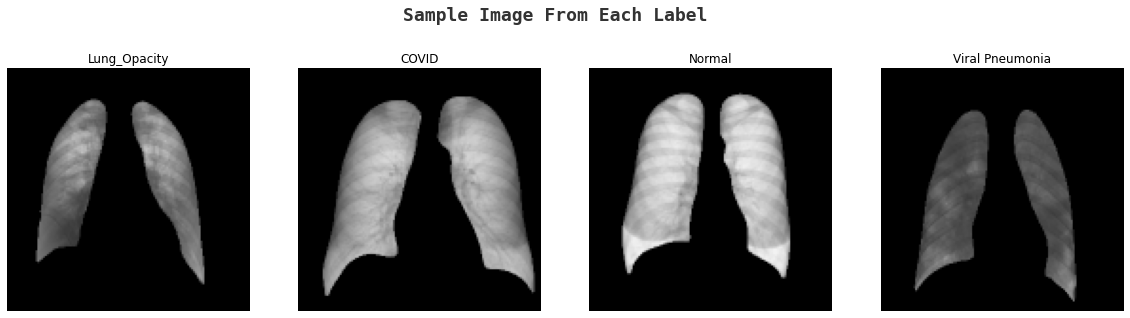

In [6]:
k=0
fig, ax = plt.subplots(1,4,figsize=(20,20))
fig.text(s='Sample Image From Each Label',size=18,fontweight='bold',
             fontname='monospace',y=0.62,x=0.4,alpha=0.8)
for i in labels:
    j=0
    while True :
        if y[j]==i:
            ax[k].imshow(X[j])
            ax[k].set_title(y[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1

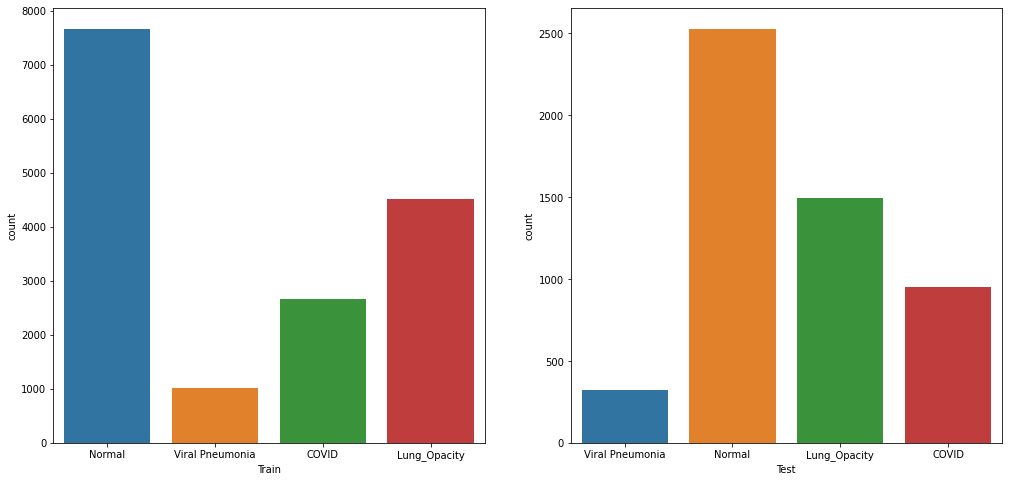

In [7]:
plt.figure(figsize = (17,8));
lis = ['Train', 'Test']
for i,j in enumerate([train_labels, test_labels]):
    plt.subplot(1,2, i+1);
    sns.countplot(x = j);
    plt.xlabel(lis[i])

In [8]:
train_images = train_images / 255.0
test_images = test_images / 255.0

In [9]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(test_labels)
test_labels_encoded = le.transform(test_labels)
le.fit(train_labels)
train_labels_encoded = le.transform(train_labels)

In [10]:
#Split data into test and train datasets (already split but assigning to meaningful convention)
x_train, y_train, x_test, y_test = train_images, train_labels_encoded, test_images, test_labels_encoded

In [11]:
#One hot encode y values for neural network. 
from tensorflow.keras.utils import to_categorical
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

In [12]:
#Load model wothout classifier/fully connected layers
ResNet50_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

#Make loaded layers as non-trainable. This is important as we want to work with pre-trained weights
for layer in ResNet50_model.layers:
	layer.trainable = False
    
ResNet50_model.summary()  #Trainable parameters will be 0

94781440/94765736 [==============================] - 4s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalizat

In [13]:
#Now, let us use features from convolutional network for RF
feature_extractor=ResNet50_model.predict(x_train)

features = feature_extractor.reshape(feature_extractor.shape[0], -1)

X_for_model= features #This is our X input for model

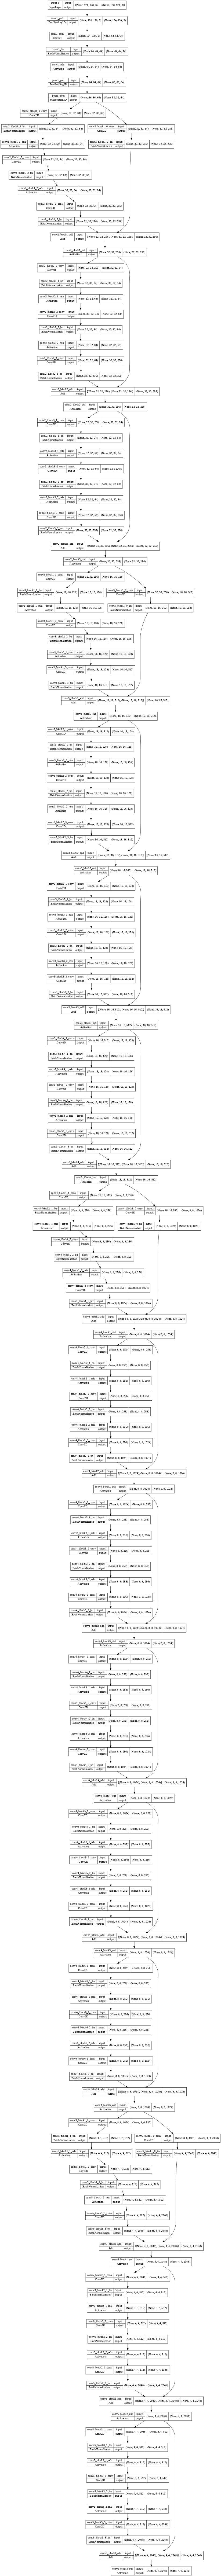

In [14]:
from keras.utils.vis_utils import plot_model

plot_model(ResNet50_model, to_file='model_plot_ResNet50_224.png', show_shapes=True, show_layer_names=True,dpi=50)

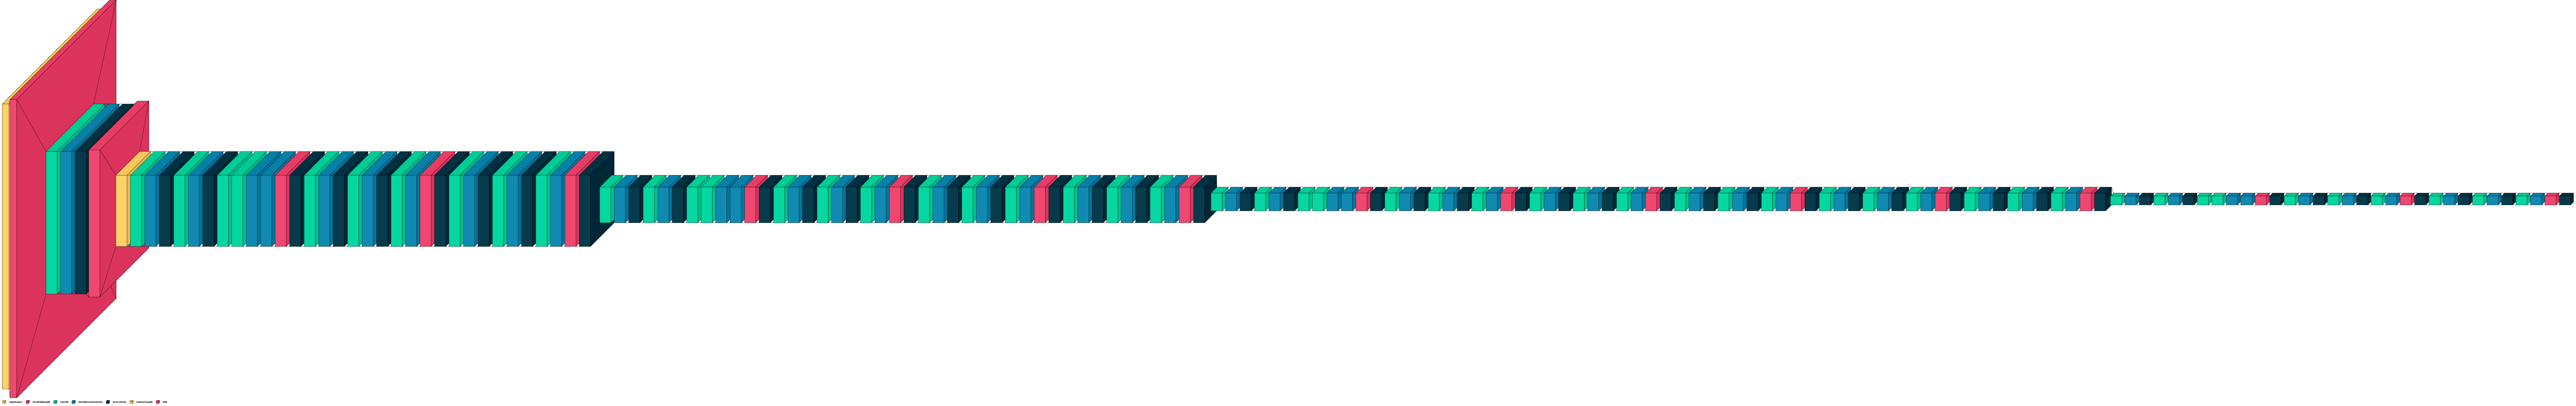

<Figure size 144x144 with 0 Axes>

In [15]:
import visualkeras
from PIL import ImageFont
plt.figure(figsize=(2, 2))
visualkeras.layered_view(ResNet50_model, legend=True,spacing=15,scale_xy = 10 , scale_z = 10, max_z = 50) 

In [16]:
from sklearn import metrics
from sklearn.model_selection import cross_val_score

def cross_val(model):
    pred = cross_val_score(model, X_for_model, y_train)
    return pred.mean()

def print_evaluate(true, predicted):  
    mae = metrics.mean_absolute_error(y_test, predicted)
    mse = metrics.mean_squared_error(y_test, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(y_test, predicted))
    r2_square = metrics.r2_score(y_test, predicted)
    Accuracy= metrics.accuracy_score(y_test,predicted)

    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('R2 Square', r2_square)
    print('Accuracy', Accuracy)



    print('__________________________________')
    
def evaluate(true, predicted):
    mae = metrics.mean_absolute_error(y_test, predicted)
    mse = metrics.mean_squared_error(y_test, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(y_test, predicted))
    r2_square = metrics.r2_score(y_test, predicted)
    Accuracy= metrics.accuracy_score(y_test,predicted)

    return mae, mse, rmse, r2_square, Accuracy

# knn

In [17]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn_model = knn.fit(X_for_model, y_train)
knn_model

KNeighborsClassifier()

In [18]:
X_test_feature = ResNet50_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)
#Now predict using the trained RF model. 
prediction = knn_model.predict(X_test_features)

In [19]:
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, prediction)

Test set evaluation:
_____________________________________
MAE: 0.367535903250189
MSE: 0.558390022675737
RMSE: 0.7472549917369151
R2 Square 0.2291334747767929
Accuracy 0.7263794406651549
__________________________________


In [20]:
results_df = pd.DataFrame(data=[["KNeighborsClassifier", *evaluate(y_test, prediction) ]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square','Accuracy_ResNet50'])
results_df

,Model,MAE,MSE,RMSE,R2 Square,Accuracy_ResNet50
0,KNeighborsClassifier,0.367536,0.55839,0.747255,0.229133,0.726379


In [21]:
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.57      0.43      0.49       949
           1       0.72      0.64      0.67      1493
           2       0.75      0.89      0.82      2527
           3       0.91      0.72      0.80       323

    accuracy                           0.73      5292
   macro avg       0.74      0.67      0.70      5292
weighted avg       0.72      0.73      0.72      5292



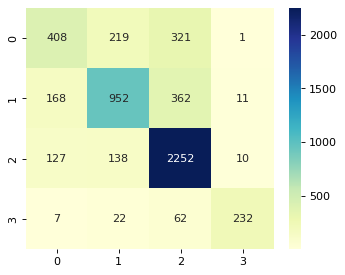

In [22]:
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
figure(figsize=(5, 4), dpi=80)
cm = confusion_matrix(y_test,prediction)

sns.heatmap(cm, annot=True,fmt="d",cmap="YlGnBu")

# DecisionTreeClassifier

In [23]:
from sklearn.tree import DecisionTreeClassifier
cart_model = DecisionTreeClassifier()
cart_model = cart_model.fit(X_for_model, y_train)
cart_model

DecisionTreeClassifier()

In [24]:
X_test_feature = ResNet50_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)
#Now predict using the trained RF model. 
prediction = cart_model.predict(X_test_features)

In [25]:
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, prediction)

Test set evaluation:
_____________________________________
MAE: 0.504724111866969
MSE: 0.778344671201814
RMSE: 0.8822384435070907
R2 Square -0.074517501656308
Accuracy 0.6249055177626606
__________________________________


In [26]:
results_df_2 = pd.DataFrame(data=[["DecisionTreeClassifier", *evaluate(y_test, prediction)]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square','Accuracy_ResNet50' ])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Accuracy_ResNet50
0,KNeighborsClassifier,0.367536,0.558390,0.747255,0.229133,0.726379
1,DecisionTreeClassifier,0.504724,0.778345,0.882238,-0.074518,0.624906


In [27]:
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.42      0.44      0.43       949
           1       0.57      0.55      0.56      1493
           2       0.74      0.73      0.73      2527
           3       0.63      0.69      0.66       323

    accuracy                           0.62      5292
   macro avg       0.59      0.60      0.59      5292
weighted avg       0.63      0.62      0.63      5292



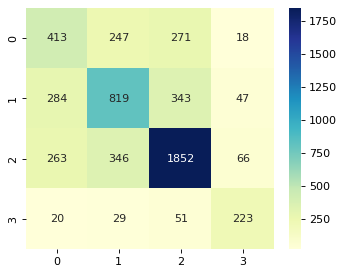

In [28]:
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
figure(figsize=(5, 4), dpi=80)
cm = confusion_matrix(y_test,prediction)

sns.heatmap(cm, annot=True,fmt="d",cmap="YlGnBu")

# Lojistik regresyon

In [29]:
from sklearn.linear_model import LogisticRegression
lr_model = LogisticRegression()
lr_model = lr_model.fit(X_for_model, y_train)
lr_model

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression()

In [30]:
X_test_feature = ResNet50_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)
#Now predict using the trained RF model. 
prediction = lr_model.predict(X_test_features)

In [31]:
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, prediction)

Test set evaluation:
_____________________________________
MAE: 0.3622448979591837
MSE: 0.5481859410430839
RMSE: 0.7403958002602958
R2 Square 0.24322037574533883
Accuracy 0.7284580498866213
__________________________________


In [32]:
results_df_2 = pd.DataFrame(data=[["LogisticRegression", *evaluate(y_test, prediction)]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square','Accuracy_ResNet50' ])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Accuracy_ResNet50
0,KNeighborsClassifier,0.367536,0.558390,0.747255,0.229133,0.726379
1,DecisionTreeClassifier,0.504724,0.778345,0.882238,-0.074518,0.624906
2,LogisticRegression,0.362245,0.548186,0.740396,0.243220,0.728458


In [33]:
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.61      0.33      0.43       949
           1       0.67      0.74      0.70      1493
           2       0.78      0.86      0.82      2527
           3       0.81      0.78      0.79       323

    accuracy                           0.73      5292
   macro avg       0.71      0.68      0.69      5292
weighted avg       0.72      0.73      0.71      5292



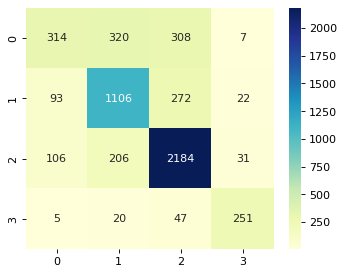

In [34]:
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
figure(figsize=(5, 4), dpi=80)
cm = confusion_matrix(y_test,prediction)

sns.heatmap(cm, annot=True,fmt="d",cmap="YlGnBu")

# LGBMClassifier

In [35]:
from lightgbm import LGBMClassifier

LGBM_model = LGBMClassifier()
LGBM_model = LGBM_model.fit(X_for_model, y_train)
LGBM_model

LGBMClassifier()

In [36]:
X_test_feature = ResNet50_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)
#Now predict using the trained RF model. 
prediction = LGBM_model.predict(X_test_features)

In [37]:
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, prediction)

Test set evaluation:
_____________________________________
MAE: 0.2853363567649282
MSE: 0.4346182917611489
RMSE: 0.6592558621363551
R2 Square 0.4000023661545258
Accuracy 0.7881708238851096
__________________________________


In [38]:
results_df_2 = pd.DataFrame(data=[["LGBMClassifier", *evaluate(y_test, prediction)]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square','Accuracy_ResNet50' ])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Accuracy_ResNet50
0,KNeighborsClassifier,0.367536,0.558390,0.747255,0.229133,0.726379
1,DecisionTreeClassifier,0.504724,0.778345,0.882238,-0.074518,0.624906
2,LogisticRegression,0.362245,0.548186,0.740396,0.243220,0.728458
3,LGBMClassifier,0.285336,0.434618,0.659256,0.400002,0.788171


In [39]:
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.73      0.49      0.59       949
           1       0.76      0.77      0.77      1493
           2       0.80      0.91      0.85      2527
           3       0.89      0.80      0.85       323

    accuracy                           0.79      5292
   macro avg       0.80      0.74      0.76      5292
weighted avg       0.78      0.79      0.78      5292



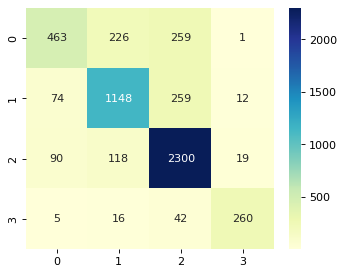

In [40]:
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
figure(figsize=(5, 4), dpi=80)
cm = confusion_matrix(y_test,prediction)

sns.heatmap(cm, annot=True,fmt="d",cmap="YlGnBu")

# RandomForestClassifier

In [41]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier()
rf_model = rf_model.fit(X_for_model, y_train)
rf_model

RandomForestClassifier()

In [42]:
X_test_feature = ResNet50_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)
#Now predict using the trained RF model. 
prediction = rf_model.predict(X_test_features)

In [43]:
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, prediction)

Test set evaluation:
_____________________________________
MAE: 0.33352229780801207
MSE: 0.49565381708238854
RMSE: 0.7040268582109552
R2 Square 0.3157418288797048
Accuracy 0.7464096749811036
__________________________________


In [44]:
results_df_2 = pd.DataFrame(data=[["RandomForestClassifier", *evaluate(y_test, prediction)]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square','Accuracy_ResNet50' ])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Accuracy_ResNet50
0,KNeighborsClassifier,0.367536,0.558390,0.747255,0.229133,0.726379
1,DecisionTreeClassifier,0.504724,0.778345,0.882238,-0.074518,0.624906
2,LogisticRegression,0.362245,0.548186,0.740396,0.243220,0.728458
3,LGBMClassifier,0.285336,0.434618,0.659256,0.400002,0.788171
4,RandomForestClassifier,0.333522,0.495654,0.704027,0.315742,0.746410


In [45]:
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.77      0.33      0.47       949
           1       0.70      0.73      0.71      1493
           2       0.75      0.92      0.83      2527
           3       0.93      0.68      0.79       323

    accuracy                           0.75      5292
   macro avg       0.79      0.67      0.70      5292
weighted avg       0.75      0.75      0.73      5292



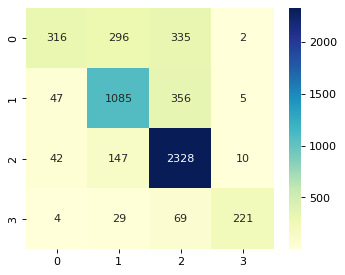

In [46]:
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
figure(figsize=(5, 4), dpi=80)
cm = confusion_matrix(y_test,prediction)

sns.heatmap(cm, annot=True,fmt="d",cmap="YlGnBu")

# GaussianNB

In [47]:
from sklearn.naive_bayes import GaussianNB


GB_model = GaussianNB()
GB_model = GB_model.fit(X_for_model, y_train)
GB_model

GaussianNB()

In [48]:
X_test_feature = ResNet50_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)
#Now predict using the trained RF model. 
prediction = GB_model.predict(X_test_features)

In [49]:
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, prediction)

Test set evaluation:
_____________________________________
MAE: 1.128495842781557
MSE: 2.0419501133786846
RMSE: 1.4289681988689198
R2 Square -1.8189454049279106
Accuracy 0.2981859410430839
__________________________________


In [50]:
results_df_2 = pd.DataFrame(data=[["GaussianNB", *evaluate(y_test, prediction)]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square','Accuracy_ResNet50' ])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Accuracy_ResNet50
0,KNeighborsClassifier,0.367536,0.558390,0.747255,0.229133,0.726379
1,DecisionTreeClassifier,0.504724,0.778345,0.882238,-0.074518,0.624906
2,LogisticRegression,0.362245,0.548186,0.740396,0.243220,0.728458
3,LGBMClassifier,0.285336,0.434618,0.659256,0.400002,0.788171
4,RandomForestClassifier,0.333522,0.495654,0.704027,0.315742,0.746410
5,GaussianNB,1.128496,2.041950,1.428968,-1.818945,0.298186


In [51]:
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.21      0.92      0.34       949
           1       0.48      0.06      0.11      1493
           2       0.82      0.18      0.30      2527
           3       0.51      0.47      0.49       323

    accuracy                           0.30      5292
   macro avg       0.50      0.41      0.31      5292
weighted avg       0.59      0.30      0.26      5292



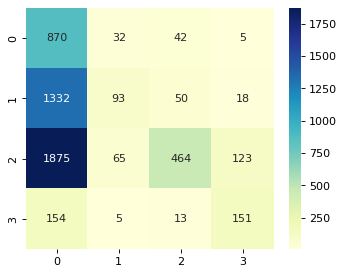

In [52]:
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
figure(figsize=(5, 4), dpi=80)
cm = confusion_matrix(y_test,prediction)

sns.heatmap(cm, annot=True,fmt="d",cmap="YlGnBu")

# SGDClassifier

In [53]:
from sklearn.linear_model import SGDClassifier

SGD_model = SGDClassifier()
SGD_model = SGD_model.fit(X_for_model, y_train)
SGD_model

SGDClassifier()

In [54]:
X_test_feature =ResNet50_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)
#Now predict using the trained RF model. 
prediction = SGD_model.predict(X_test_features)

In [55]:
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, prediction)

Test set evaluation:
_____________________________________
MAE: 0.30536659108087677
MSE: 0.46674225245653816
RMSE: 0.6831853719573759
R2 Square 0.35565471495725165
Accuracy 0.7738095238095238
__________________________________


In [56]:
results_df_2 = pd.DataFrame(data=[["SGDClassifier", *evaluate(y_test, prediction)]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square','Accuracy_ResNet50' ])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Accuracy_ResNet50
0,KNeighborsClassifier,0.367536,0.558390,0.747255,0.229133,0.726379
1,DecisionTreeClassifier,0.504724,0.778345,0.882238,-0.074518,0.624906
2,LogisticRegression,0.362245,0.548186,0.740396,0.243220,0.728458
3,LGBMClassifier,0.285336,0.434618,0.659256,0.400002,0.788171
4,RandomForestClassifier,0.333522,0.495654,0.704027,0.315742,0.746410
5,GaussianNB,1.128496,2.041950,1.428968,-1.818945,0.298186
6,SGDClassifier,0.305367,0.466742,0.683185,0.355655,0.773810


In [57]:
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.76      0.38      0.51       949
           1       0.72      0.80      0.76      1493
           2       0.79      0.91      0.85      2527
           3       0.96      0.76      0.84       323

    accuracy                           0.77      5292
   macro avg       0.81      0.71      0.74      5292
weighted avg       0.77      0.77      0.76      5292



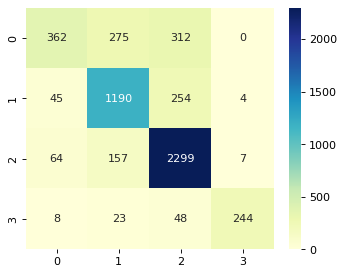

In [58]:
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
figure(figsize=(5, 4), dpi=80)
cm = confusion_matrix(y_test,prediction)

sns.heatmap(cm, annot=True,fmt="d",cmap="YlGnBu")

# SVC

In [59]:
from sklearn.svm import SVC
svm_model = SVC(kernel = "linear")
svm_model = svm_model.fit(X_for_model, y_train)
svm_model

SVC(kernel='linear')

In [60]:
X_test_feature = ResNet50_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)
#Now predict using the trained RF model. 
prediction = svm_model.predict(X_test_features)

In [61]:
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, prediction)

Test set evaluation:
_____________________________________
MAE: 0.29780801209372637
MSE: 0.4580498866213152
RMSE: 0.6767938287405665
R2 Square 0.3676546676341611
Accuracy 0.7806122448979592
__________________________________


In [62]:
results_df_2 = pd.DataFrame(data=[["SVC", *evaluate(y_test, prediction)]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square','Accuracy_ResNet50' ])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Accuracy_ResNet50
0,KNeighborsClassifier,0.367536,0.558390,0.747255,0.229133,0.726379
1,DecisionTreeClassifier,0.504724,0.778345,0.882238,-0.074518,0.624906
2,LogisticRegression,0.362245,0.548186,0.740396,0.243220,0.728458
3,LGBMClassifier,0.285336,0.434618,0.659256,0.400002,0.788171
4,RandomForestClassifier,0.333522,0.495654,0.704027,0.315742,0.746410
5,GaussianNB,1.128496,2.041950,1.428968,-1.818945,0.298186
6,SGDClassifier,0.305367,0.466742,0.683185,0.355655,0.773810
7,SVC,0.297808,0.458050,0.676794,0.367655,0.780612


In [63]:
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.67      0.54      0.60       949
           1       0.76      0.76      0.76      1493
           2       0.81      0.87      0.84      2527
           3       0.89      0.86      0.87       323

    accuracy                           0.78      5292
   macro avg       0.78      0.76      0.77      5292
weighted avg       0.78      0.78      0.78      5292



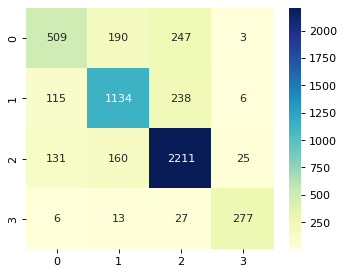

In [64]:
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
figure(figsize=(5, 4), dpi=80)
cm = confusion_matrix(y_test,prediction)

sns.heatmap(cm, annot=True,fmt="d",cmap="YlGnBu")

In [65]:
modeller = [rf_model,GB_model,LGBM_model,SGD_model,lr_model,cart_model,svm_model,knn_model]


In [66]:
sonuc = []
from sklearn.metrics import accuracy_score

sonuclar = pd.DataFrame(columns= ["Modeller","Accuracy_ResNet50"])

for model in modeller:
    isimler = model.__class__.__name__
    y_pred = model.predict(X_test_features)
    dogruluk = accuracy_score(y_test, y_pred)    
    sonuc = pd.DataFrame([[isimler, dogruluk*100]], columns= ["Modeller","Accuracy_ResNet50"])
    sonuclar = sonuclar.append(sonuc)
    

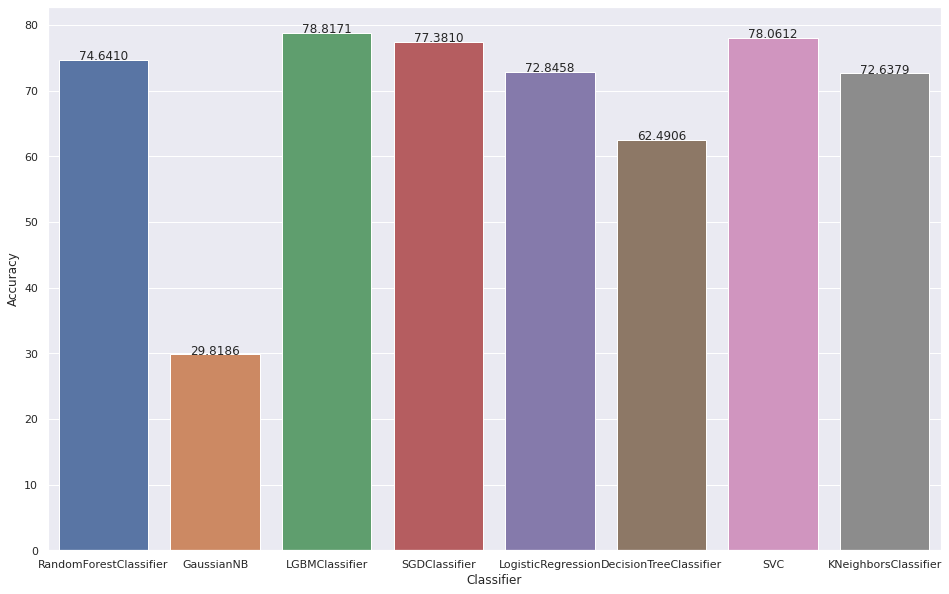

In [71]:
plt.figure(figsize=[16, 10])
axis = sns.barplot(x = 'Modeller', y = 'Accuracy_ResNet50', data = sonuclar)
axis.set(xlabel='Classifier', ylabel='Accuracy')
for p in axis.patches:
  height = p.get_height()
  axis.text(p.get_x() + p.get_width()/2, height + 0.005, '{:1.4f}'.format(height), ha="center")

In [72]:
best_acc=sonuclar.sort_values(by=['Accuracy_ResNet50'], ascending=False)
en_iyi_model_my_model=best_acc[:1]
en_iyi_model_my_model

,Modeller,Accuracy_ResNet50
0,LGBMClassifier,78.817082


In [73]:
results_df


,Model,MAE,MSE,RMSE,R2 Square,Accuracy_ResNet50
0,KNeighborsClassifier,0.367536,0.558390,0.747255,0.229133,0.726379
1,DecisionTreeClassifier,0.504724,0.778345,0.882238,-0.074518,0.624906
2,LogisticRegression,0.362245,0.548186,0.740396,0.243220,0.728458
3,LGBMClassifier,0.285336,0.434618,0.659256,0.400002,0.788171
4,RandomForestClassifier,0.333522,0.495654,0.704027,0.315742,0.746410
5,GaussianNB,1.128496,2.041950,1.428968,-1.818945,0.298186
6,SGDClassifier,0.305367,0.466742,0.683185,0.355655,0.773810
7,SVC,0.297808,0.458050,0.676794,0.367655,0.780612


In [70]:
from google.colab import files

results_df.to_csv('output_resnet50_224.csv', encoding = 'utf-8-sig') 
files.download('output_resnet50_224.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>